U-Net Nucleii maschează EDA

Part of Kaggle's 2018 Data Sciene Bowl
  * https://www.kaggle.com/c/data-science-bowl-2018


#### Nuclei la fața locului. Vindecări de viteză.

Imaginați-vă că grăbiți cercetarea pentru aproape fiecare boală, de la cancerul pulmonar și boli de inimă la tulburări rare. Bowl Data Science 2018 oferă misiunea noastră cea mai ambițioasă încă: crearea unui algoritm pentru automatizarea detectării nucleului.

Cu toții am văzut că oamenii suferă de boli precum cancerul, boli de inimă, boli pulmonare obstructive cronice, Alzheimer și diabet. Mulți și-au văzut persoanele dragi decedand. Gândește-te câte vieți ar fi transformate dacă vindecările ar veni mai repede.

Automatizând detectarea nucleului, puteți ajuta la deblocarea vindecărilor mai repede - de la tulburări rare la frig comun. Doriți o instantanee despre Bowl Data Science 2018? [Vizualizați acest videoclip.](https://www.youtube.com/watch?v=eHwkfhmJexs&feature=youtu.be)

O mulțime de lucrări din această lucrare a fost asigurată de Kjetil Åmdal-SævikKeras, care a făcut ca „U-Net starter - LB 0.277” să fie cel mai bine cotat Kernel de pe Kaggle.
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

In [1]:
import os 
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = "c:/Users/Harum/Documents/19/U_NET/train/"
TEST_PATH = "c:/Users/Harum/Documents/19/U_NET/validation/"

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed


Using TensorFlow backend.


# Colectarea numelor fisierelor pentru instruirea si testarea datelor

In [2]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Crearea mastilor de imagine cu dimensiunea de 128 x 128 (imagine neagra)

In [3]:
print('Getting and resizing training images ...')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype= np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

#Re-dimensionare imaginilor de instruire la 128 x 128
#Note sys.stdout tipărește informații care pot fi șterse spre deosebire de tipărire.
# Utilizarea TQDM ne permite să creăm bare de progres
sys.stdout.flush ()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' +id_ + '.png')[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    # Acum luăm toate măștile asociate cu acea imagine și le combinăm într-o singură mască
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    #Y_train este acum o singura noastra masca asoicata cu imaginea
    Y_train[n] = mask

#Optine si redimensioneaza imaginile de testare
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images...')
sys.stdout.flush()

#Aici vom redimensiona imanile de testare
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img  = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print("Done")

Getting and resizing training images ...
100%|██████████| 670/670 [06:00<00:00,  1.86it/s]Getting and resizing test images...

100%|██████████| 65/65 [00:01<00:00, 33.29it/s]Done



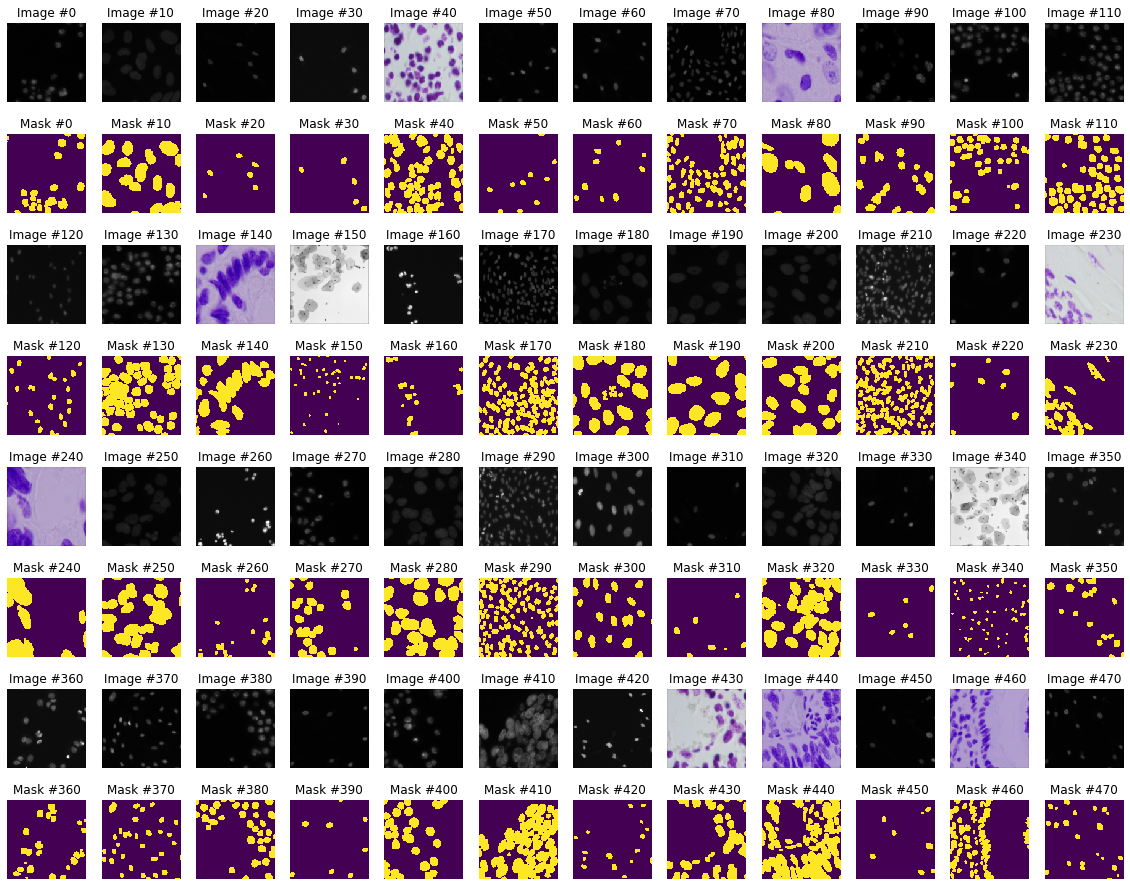

In [4]:
#Ilustreaza imaginile de instruire si mastile
plt.figure(figsize=(20,16))
x,y = 12, 4
for i in range(y):
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)

        #Afișăm masca asociată pe care tocmai am generat-o mai sus cu imaginea de instruire
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')

plt.show()


# Definim o metrică personalizată numită Intersecție peste Uniune (IoU)

In [5]:
# Definim matricea IoU
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.matrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score =tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [6]:
#Funcție alternativă IoU
#https://www.kaggle.com/c/data-science-bowl-2018/discussion/51553
def iou_coef(y_true, y_pred, smooth=1):
    """
    IoU = (|X & Y|) / (X or Y|)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum((y_true, -1) + K.sum(y_pred, -1) - intersection)
    return (intersection + smooth) / (union + smooth)

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

# o alta matrice IoU
      * https://www.kaggle.com/aglotero/another-iou-metric

In [23]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    #Calculează zonele (necesare pentru găsirea unirii între toate obiectele)
    area_true = np.histogram(labels, bins= true_objects)[0]
    area_pred = np.histogram(y_pred, bins= pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    #Compute union
    union = area_true + area_pred - intersection

    #Excludeți fundalul din analiză
    intersection = intersection[1:, 1:]
    union =union[1:, 1:]
    union[union ==0] = 1e-9

    #Calculați intersecția cu unirea
    iou = intersection / union

    # Functia de ajutor precizie
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1 #corect opbiecte
        false_positives = np.sum(matches, axis=0) == 0 #lipseste obiectele
        false_negatives = np.sum(matches, axis=1) == 0 #Extrage obiectelor
        tp, fp, fn = np.sum(true_positives), np.sum(false_negatives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp +fn) > 0:
            p = tp / (tp + fp +fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)

    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range (batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [ label, pred], tf.float32)
    return metric_value

# Construirea modelului U-Net

In [24]:
#Rețineți că facem straturile noastre viabile, astfel încât să putem concatena sau stiva
# Acest lucru este necesar pentru a putea re-crea modelul nostru U-Net

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x : x / 255)(inputs)

c1 = Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal',
padding='same')(c2)
p2 =MaxPooling2D((2,2))(c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)


u6 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16,(3,3),activation='elu', kernel_initializer='he_normal', padding='same')(c9)

#Rețineți că output-ul noastră este efectiv o mască de 128 x 128
outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

model = Model(input=[inputs], outputs=[outputs])
model.compile('adam','binary_crossentropy', metrics=[my_iou_metric])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 128, 128, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 128, 128, 16) 448         lambda_5[0][0]                   
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 128, 128, 16) 0           conv2d_77[0][0]                  
____________________________________________________________________________________________

# Fit model

In [33]:
# initializam callbacks
model_path = "c:/Users/Harum/Documents/19/nuclei_finder_unet_1.h5"

checkpoint = ModelCheckpoint(model_path,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1  
                               )
        
earlystop = EarlyStopping(monitor='val_loss',
                         min_delta=0,
                         patience=10,
                         verbose=1,
                         restore_best_weights=True
                         )
    
#fit model
results = model.fit(X_train, Y_train, validation_split=0.1,
                    batch_size=16,
                    epochs=20,
                    callbacks=[earlystop, checkpoint]
                    )

Train on 603 samples, validate on 67 samples
Epoch 1/20
603/603 [==============================] - 5s 8ms/step - loss: 0.0876 - my_iou_metric: 0.5507 - val_loss: 0.0787 - val_my_iou_metric: 0.6350

Epoch 00001: val_loss improved from inf to 0.07868, saving model to c:/Users/Harum/Documents/19/nuclei_finder_unet_1.h5
Epoch 2/20
603/603 [==============================] - 5s 8ms/step - loss: 0.0854 - my_iou_metric: 0.5512 - val_loss: 0.0822 - val_my_iou_metric: 0.6433

Epoch 00002: val_loss did not improve from 0.07868
Epoch 3/20
603/603 [==============================] - 5s 8ms/step - loss: 0.0864 - my_iou_metric: 0.5483 - val_loss: 0.0842 - val_my_iou_metric: 0.6119

Epoch 00003: val_loss did not improve from 0.07868
Epoch 4/20
603/603 [==============================] - 5s 8ms/step - loss: 0.0848 - my_iou_metric: 0.5636 - val_loss: 0.0769 - val_my_iou_metric: 0.6165

Epoch 00004: val_loss improved from 0.07868 to 0.07692, saving model to c:/Users/Harum/Documents/19/nuclei_finder_unet_1.

# Generati predicti pentru instruire si validare a datelor

In [34]:
#Predictia in instruire si validare a datelor
#Note utilizam mean_iou metri

model = load_model('c:/Users/Harum/Documents/19/nuclei_finder_unet_1.h5', custom_objects={'my_iou_metric':my_iou_metric})

#primele 90% au fost folosite pentru instruire
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)

#ultimele 10% au fost folosite pentru validare
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

#Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

67/67 [==============================] - 0s 2ms/step


# Aratarea mastilor de predictie in datele de instruire

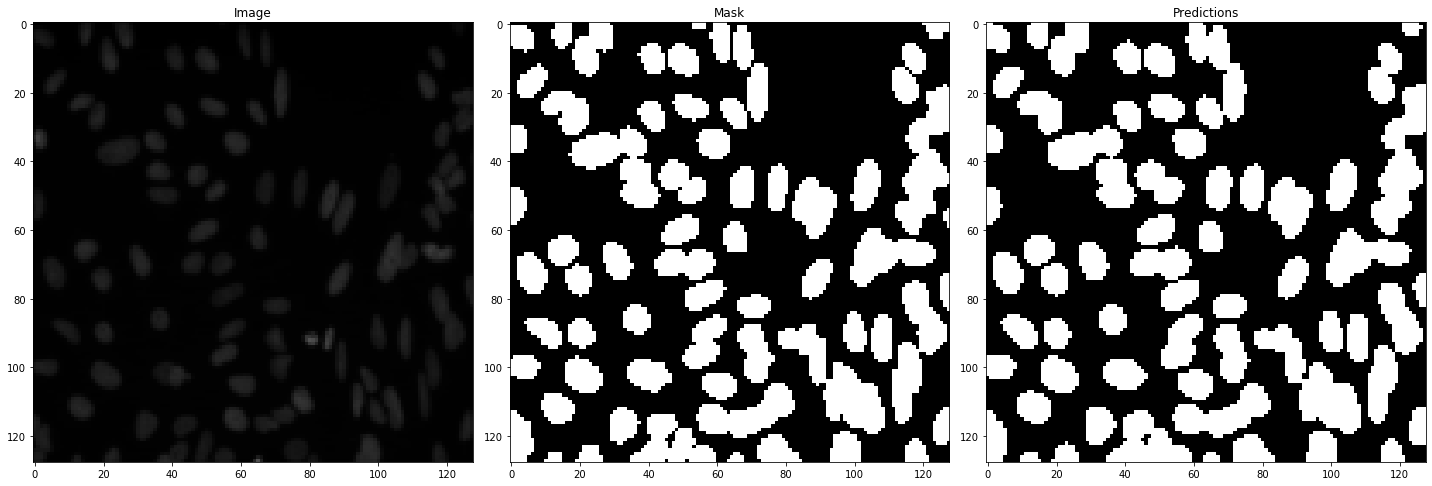

In [35]:
#ploting masca prezisa
ix = random.randint(0, 602)
plt.figure(figsize=(20,20))

#Imaginea originala de instruire
plt.subplot(131)
imshow(X_train[ix])
plt.title('Image')

#mastile combinate originale
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")

#Mastile prezise din modelul U-Net
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show() 

# Arata mastile prezise in datele de validare

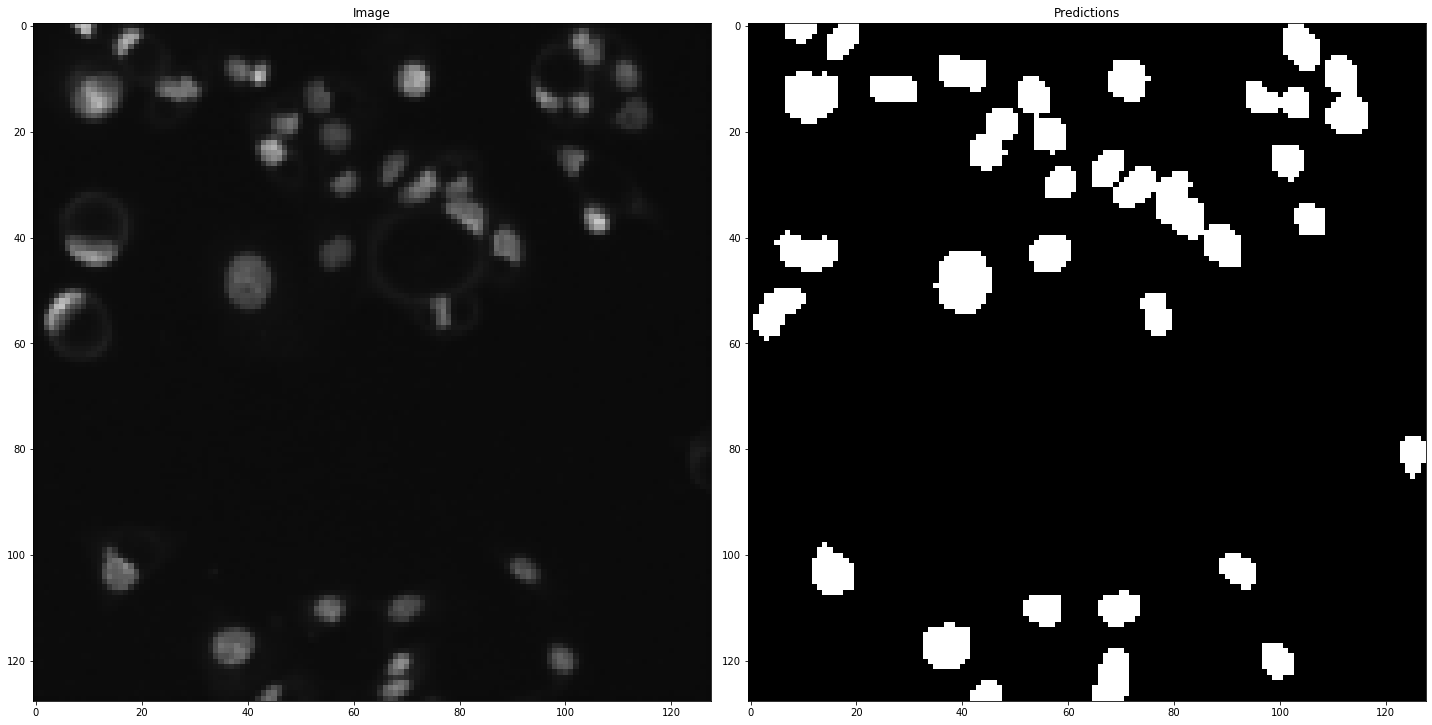

In [36]:
##ploting masca prezisa
ix = random.randint(602, 668)
plt.figure(figsize=(20,20))

#Imaginea originala de instruire
plt.subplot(121)
imshow(X_train[ix])
plt.title('Image')

#Mastile prezise din modelul U-Net
plt.subplot(122)
ix = ix - 603
imshow(np.squeeze(preds_val_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

# Genereaza un raport al clasificatorului

In [37]:
iou_metric(np.squeeze(Y_train[ix]), np.squeeze(preds_train_t[ix]), print_table=True)

Thresh	TP	FP	FN	Prec.
0.500	16	0	0	1.000
0.550	16	0	0	1.000
0.600	16	0	0	1.000
0.650	16	0	0	1.000
0.700	16	0	0	1.000
0.750	16	0	0	1.000
0.800	16	0	0	1.000
0.850	16	0	0	1.000
0.900	15	1	1	0.882
0.950	6	10	10	0.231
AP	-	-	-	0.911


0.9113122171945701